# DBCV Experiments

### Import necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, datasets, mixture
from src.Evaluation.dcdistances.dctree import DCTree
from src.Evaluation.CDBW.cdbw import cdbw_score as CDBW
from src.Evaluation.CVDD.cvdd import cvdd_score as CVDD
from src.Evaluation.DBCV.dbcv import dbcv_score as DBCV
from src.Evaluation.DCSI.dcsi import dcsi_score as DCSI
from src.Evaluation.DISCO.disco import disco_score as DISCO
from src.Evaluation.DC_DUNN.dc_dunn import dc_dunn_score as DC_DUNN
from src.Evaluation.S_Dbw.sdbw import sdbw_score as S_DBW
from src.Evaluation.Silhouette.silhouette import silhouette_score as SILHOUETTE

### Load data

In [2]:
## load data
data_frame = pd.read_csv('data/datasets/dataset_1.csv')
#data_frame = pd.read_csv('data/synthetic_2_2.csv')
data = data_frame.copy()
print(data.columns)
# we need labels
labels = data['cluster'].astype(int).to_numpy()
# first ten are features rest are groundtruth cluster and sensitive attribute
features = data.iloc[:, : 2].to_numpy()
# drop ground truth from dataframe
data = data.drop('cluster', axis=1)
# this includes also the binary sensitive attribute
features_incl_sensitive = data.to_numpy()

Index(['Feature_1', ' Feature_2', 'cluster'], dtype='object')


### Plot attributes for this dataset

In [3]:
def plot_dataset():
    df_subset = data_frame.copy()
    df_subset['cluster'] =df_subset['cluster'].astype(int)
    cols = ['0', '1', '2', '3', '4','5','6','7','8','9', 'cluster']
    pp = sns.pairplot(df_subset[cols], hue='cluster', size=1.8, aspect=1.8, 
                      palette={0: "#FF9999", 1: "#FFE888"},
                      plot_kws=dict(edgecolor="black", linewidth=0.5))
    fig = pp.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('Dataset Attributes Pairwise Plots', fontsize=14)
    
#plot_dataset()

### DBCV Experiments

### Shuffle the dataset

In [4]:
def shuffle():
    #shuffle dataset
    shuffled_data = data_frame.copy()
    shuffled_data = shuffled_data.sample(frac = 1)
    # we need labels
    shuffled_labels = shuffled_data['cluster'].astype(int).to_numpy()
    # first ten are features rest are groundtruth cluster and sensitive attribute
    shuffled_features = shuffled_data.iloc[:, : 10].to_numpy()
    return shuffled_features, shuffled_labels

In [5]:
def plot(n, shuffle_report):
    x = range(n)
    report_series = pd.Series(shuffle_report)
    # Plot the figure.
    plt.figure(figsize=(12, 8))
    ax = report_series.plot(kind="bar")
    ax.set_title("DBCV over {}-Shuffle-Runs".format(n))
    ax.set_xlabel("Run")
    ax.set_ylabel("DBCV")

In [6]:
def plot_kde(shuffle_report, name="DBCV"):
    report_series = pd.DataFrame(shuffle_report,columns=[name])
    sns.displot(report_series, x=name, kind="kde")

In [7]:
def run_multiple_shuffle_runs(n, algorithm):
        shuffle_report = []
        shuffle_squared = []
        shuffle_original = []
        shuffle_test = []
        silhouette_scores= []
        silhouette_score_dc= []
        for i in range(n):
            shuffled_features, shuffled_labels = shuffle()
            dbcv_shuffle, internal_mst_per_cluster_shuffle = DBCV(shuffled_features, shuffled_labels, algorithm=algorithm)
            shuffle_report.append(dbcv_shuffle)
            dbcv_shuffle, internal_mst_per_cluster_shuffle = DBCV(shuffled_features, shuffled_labels,metric = 'sqeuclidean', algorithm=algorithm)
            shuffle_squared.append(dbcv_shuffle)
            dbcv_shuffle, internal_mst_per_cluster_shuffle = DBCV(shuffled_features, shuffled_labels,metric = 'sqeuclidean', algorithm='kruskal_claudius')
            shuffle_original.append(dbcv_shuffle)
            silhouette_scores.append(SILHOUETTE(shuffled_features, shuffled_labels))
            dc_distances = DCTree(shuffled_features, no_fastindex=False).dc_distances()
            silhouette_score_dc.append(SILHOUETTE(dc_distances, shuffled_labels,metric='precomputed'))
        return [shuffle_report, shuffle_squared, shuffle_original,shuffle_test],[silhouette_scores, silhouette_score_dc]

In [8]:
def plot_shuffle_results(dbcv_list, silhouette_list):
    for dbcvs in dbcv_list:
        plot_kde(dbcvs)
    plot_kde(silhouette_list[0], name='Silhouette_Score')
    plot_kde(silhouette_list[1], name='Silhouette_Score_DC')

In [9]:
#algorithm = 'prim_official'
#n = 100
#dbcv_list, silhouette_list = run_multiple_shuffle_runs(n, algorithm)
#plot_shuffle_results(dbcv_list, silhouette_list)

## Look at two Blob and two moons 

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
n_samples = 1000
seed = 1234

In [12]:
X_moons, y_moons = datasets.make_moons(n_samples=n_samples, noise = 0, random_state=seed)
X_blobs, y_blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed, centers=[[0,0],[0,10]])

### Silhouette Score

In [13]:
def calculate_both_silhouette_scores(X, y): 
    silhouette = SILHOUETTE(X,y)
    disco_ = DISCO(X, y, min_points=5)
    return silhouette, disco_
    

In [14]:
silhouette_data, disco_data = calculate_both_silhouette_scores(features, labels)
dc_dunn_data = DC_DUNN(features, labels)

In [15]:
silhouette_moons, disco_moons = calculate_both_silhouette_scores(X_moons, y_moons)
dc_dunn_moons = DC_DUNN(X_moons, y_moons)

In [16]:
silhouette_blobs, disco_blobs = calculate_both_silhouette_scores(X_blobs, y_blobs)
dc_dunn_blobs = DC_DUNN(X_blobs, y_blobs)

/var/folders/nc/bk5y8hg15dj22klbh0nsdc400000gn/T/ipykernel_41097/848215305.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


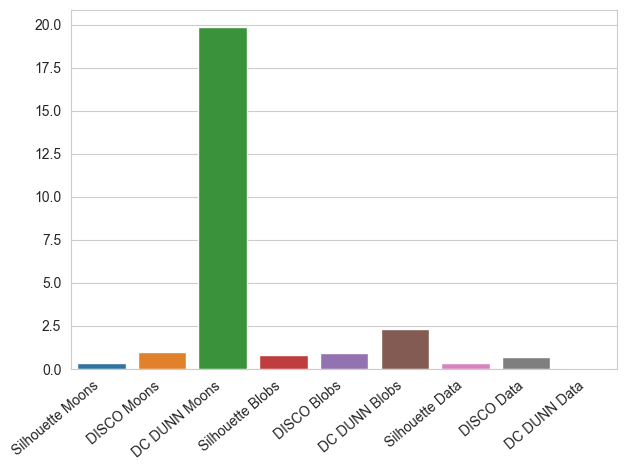

In [17]:
silhouette_df = pd.DataFrame(np.array([[silhouette_moons, disco_moons, dc_dunn_moons, silhouette_blobs, disco_blobs, dc_dunn_blobs, silhouette_data, disco_data, dc_dunn_data]]), columns = ['Silhouette Moons', 'DISCO Moons', 'DC DUNN Moons', 'Silhouette Blobs', 'DISCO Blobs','DC DUNN Blobs', 'Silhouette Data', 'DISCO Data','DC DUNN Data'])
ax = sns.barplot(silhouette_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()